<a href="https://colab.research.google.com/github/airsresincrop/AIRS/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!gdown https://drive.google.com/uc?id=1jcQtXg8bYzTlgCMcxDqEYuC62j1XKf3t # AIRS_128.zip
!gdown https://drive.google.com/uc?id=1MohUSBykyDu94E1PTRelC5h0dA-LuuU1 # AIRS_256.zip
!gdown https://drive.google.com/uc?id=1rxR0XTiDbPeJg88WLZctzPwuL9JquC4g # AIRS_512.zip
!gdown https://drive.google.com/uc?id=1-5BDBZL8Tsxzi_wshN3d_EF6Zhn2iitY # AIRS_1024.zip
!gdown https://drive.google.com/uc?id=1a5A8xat3wJmEx11ml1UUqhTjMKbMFkG9 # AIRS_2048.zip
!gdown https://drive.google.com/uc?id=1-F3N0NBorYSIikB_my4NY8t8NI2NAjk6 # AIRS_4096.zip
!gdown https://drive.google.com/uc?id=1-2p-z1L2CWI-dr0EDj-9Ve5MXGBurEQI # AIRS_8192.zip
!gdown https://drive.google.com/uc?id=1-CsjdU3xVDiIuWQ0s95vKC9ceT6a7Vmb # AIRS_10000.zip

In [4]:
!pip install -U tensorboard
!gdown https://drive.google.com/uc?id=1-5BDBZL8Tsxzi_wshN3d_EF6Zhn2iitY
!unzip -qq AIRS_1024.zip
!rm AIRS_1024.zip

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.2.1)
Downloading...
From: https://drive.google.com/uc?id=1-5BDBZL8Tsxzi_wshN3d_EF6Zhn2iitY
To: /content/AIRS_1024.zip
231MB [00:07, 32.6MB/s]


In [0]:
import tensorflow as tf
import os
import time
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from IPython import display

In [6]:
number = 1024
dataset = 'crop_512'
for split in ['train','val','test']:
  images = files = [f[:-4] for f in os.listdir(f'full_data/AIRS_{number}/{dataset}/{split}/images/') if 'jpg' in f]
  Path(f'AIRS_{number}/{split}').mkdir(parents = True, exist_ok = True)
  for f in tqdm(images, desc = split):
    img = plt.imread(f'full_data/AIRS_{number}/{dataset}/{split}/images/{f}.jpg')
    lbl = plt.imread(f'full_data/AIRS_{number}/{dataset}/{split}/labels/{f}.tif')*255
    stack = np.concatenate([img, lbl],axis=1)
    plt.imsave(f'AIRS_{number}/{split}/{f}.png',stack)

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)[:,:,:3]

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, w:, :]
  input_image = image[:, :w, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator(factor=1):
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])

  down_stack = [
    downsample(64//factor, 3, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128//factor, 3), # (bs, 128, 128, 128)
    downsample(256//factor, 3), # (bs, 64, 64, 256)
    downsample(512//factor, 3), # (bs, 32, 32, 512)
    downsample(512//factor, 3), # (bs, 16, 16, 512)
    downsample(512//factor, 3), # (bs, 8, 8, 512)
    downsample(512//factor, 3), # (bs, 4, 4, 512)
    downsample(512//factor, 3), # (bs, 2, 2, 512)
    downsample(512, 3), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512//factor, 3, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512//factor, 3, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512//factor, 3, apply_dropout=True), # (bs, 16, 16, 1024)
    upsample(512//factor, 3), # (bs, 32, 32, 1024)
    upsample(256//factor, 3), # (bs, 64, 64, 512)
    upsample(128//factor, 3), # (bs, 128, 128, 256)
    upsample(64//factor, 3), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  #l2_loss = tf.reduce_mean(tf.square(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def Discriminator(factor=1):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 512, 512, channels*2)

  down1 = downsample(64//factor, 3, False)(x) # (bs, 256, 256, 64)
  down2 = downsample(128//factor, 3)(down1) # (bs, 128, 128, 128)
  down3 = downsample(256//factor, 3)(down2) # (bs, 64, 64, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 66, 66, 256)
  conv = tf.keras.layers.Conv2D(512//factor, 3, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 63, 63, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 65, 65, 512)

  last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 62, 62, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=False)

  pred = np.array(prediction[0]*0.5+0.5)
  t = np.array(tar[0]*0.5+0.5)
  pred[pred>0.5] = 1
  pred[pred<=0.5] = 0
  fore_inter = np.logical_and(pred,t).sum()
  fore_union = np.logical_or(pred,t).sum()
  back_inter = np.logical_and(1-pred,1-t).sum()
  back_union = np.logical_or(1-pred,1-t).sum()
  miou = (fore_inter/fore_union + back_inter/back_union)/2
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  print(f'mIoU: {miou}')

def test_miou(model, test_dataset):
  preds = np.zeros((len(os.listdir(f'{PATH}test')),IMG_HEIGHT,IMG_WIDTH,3),dtype = np.uint8)
  ts = np.zeros((len(os.listdir(f'{PATH}test')),IMG_HEIGHT,IMG_WIDTH,3),dtype = np.uint8)
  count = 0
  for inp, tar in test_dataset.take(20):
    prediction = model(inp, training=False)
    pred = np.array(prediction[0]*0.5+0.5)
    t = np.array(tar[0]*0.5+0.5)
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    preds[count] = pred
    ts[count] = t
    count += 1
  fore_inter = np.logical_and(preds,ts).sum()
  fore_union = np.logical_or(preds,ts).sum()
  back_inter = np.logical_and(1-preds,1-ts).sum()
  back_union = np.logical_or(1-preds,1-ts).sum()
  miou = (fore_inter/fore_union + back_inter/back_union)/2
  print(f'mIoU: {miou}')
  return preds, ts, miou

In [0]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
PATH = f'AIRS_{number}/'
gen_factor = 1
disc_factor = 1
LAMBDA = 100

In [0]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 572 x 572 x 3
  input_image, real_image = resize(input_image, real_image, int(1.1171875*IMG_WIDTH), int(1.1171875*IMG_HEIGHT))

  # randomly cropping to 512 x 512 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

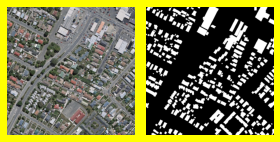

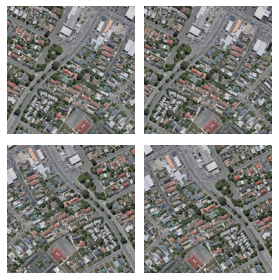

In [94]:
inp, re = load(PATH+'train/99.png')
# casting to int for matplotlib to show the image
fig = plt.figure(figsize=(4,4))
plt.subplot(121)
plt.imshow(inp/255.0)
plt.axis('off')
plt.tight_layout()
plt.subplot(122)
plt.imshow(re/255.0)
plt.axis('off')
plt.tight_layout()
fig.set_facecolor('yellow')
fig = plt.figure(figsize=(4, 4))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
fig.tight_layout()

In [0]:
middle = sorted(os.listdir('AIRS_1024/train'),key=lambda x:int(x.split('.')[0]))
middle = middle[len(middle)//4:len(middle)*3//4]

In [0]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/1[0-9][0-9].png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.list_files(PATH+'val/*.png')
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
OUTPUT_CHANNELS = 3

In [98]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)
(1, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


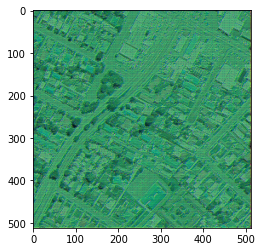

In [99]:
#generator = Generator()
generator = Generator(factor=gen_factor)
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

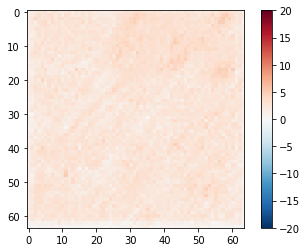

In [101]:
#discriminator = Discriminator()
discriminator = Discriminator(disc_factor)
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

In [0]:
EPOCHS = 100

In [0]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    #tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    #tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [0]:
def fit(train_ds, val_ds, epochs, test_ds):
  best_miou = 0
  for epoch in range(epochs):
    start = time.time()
    
    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # Validate
    _, _, miou = test_miou(generator, val_ds)
    print(f'Validation mIoU: {miou:.4f}')
    with summary_writer.as_default():
      tf.summary.scalar('val_miou', miou, step=epoch)
    if miou > best_miou:
      print('Best mIoU so far, saving checkpoint')
      manager.save()
      best_miou = miou

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [108]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 578), started 2:49:27 ago. (Use '!kill 578' to kill it.)

<IPython.core.display.Javascript object>

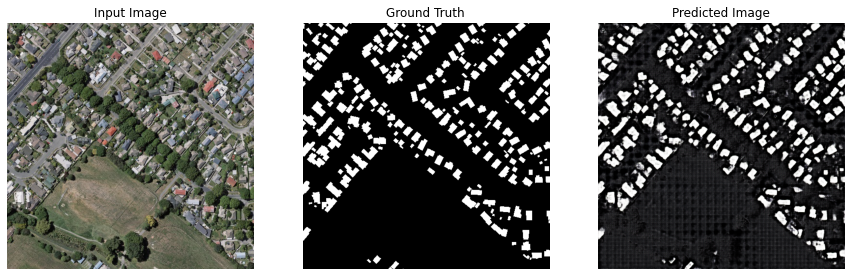

mIoU: 0.8414307107127222
Epoch:  49
............

In [0]:
fit(train_dataset, val_dataset, EPOCHS, test_dataset)

In [52]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [53]:
print(f'gen_factor: {gen_factor}, disc_factor: {disc_factor}')
preds, ts, miou = test_miou(generator, test_dataset)

gen_factor: 1, disc_factor: 1
mIoU: 0.8828346406770631
